In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random

In [2]:
def generate_rook_blocker_mask(square):
    mask = 0
    rank = square // 8
    file = square % 8

    # Ruch w górę
    for r in range(rank + 1, 7):
        mask |= 1 << (r * 8 + file)
    # Ruch w dół
    for r in range(rank - 1, 0, -1):
        mask |= 1 << (r * 8 + file)
    # Ruch w prawo
    for f in range(file + 1, 7):
        mask |= 1 << (rank * 8 + f)
    # Ruch w lewo
    for f in range(file - 1, 0, -1):
        mask |= 1 << (rank * 8 + f)

    return mask

def generate_blocker_variations(mask):
    bits = [i for i in range(64) if (mask >> i) & 1]
    variation_count = 1 << len(bits)
    blockers = []

    for index in range(variation_count):
        blocker = 0
        for i, bit in enumerate(bits):
            if (index >> i) & 1:
                blocker |= 1 << bit
        blockers.append(blocker)
    return blockers

def compute_rook_attacks(square, blockers):
    attacks = 0
    rank = square // 8
    file = square % 8

    # W górę
    for r in range(rank + 1, 8):
        sq = r * 8 + file
        attacks |= 1 << sq
        if blockers & (1 << sq): break
    # W dół
    for r in range(rank - 1, -1, -1):
        sq = r * 8 + file
        attacks |= 1 << sq
        if blockers & (1 << sq): break
    # W prawo
    for f in range(file + 1, 8):
        sq = rank * 8 + f
        attacks |= 1 << sq
        if blockers & (1 << sq): break
    # W lewo
    for f in range(file - 1, -1, -1):
        sq = rank * 8 + f
        attacks |= 1 << sq
        if blockers & (1 << sq): break

    return attacks


def generate_rook_attack_table(square):
    mask = generate_rook_blocker_mask(square)
    blocker_variations = generate_blocker_variations(mask)

    attack_table = {}

    for blockers in blocker_variations:
        attack = compute_rook_attacks(square, blockers)
        attack_table[blockers] = attack

    return attack_table

In [3]:
rook_almost_magic_table = []

for i in range(64):
    rook_almost_magic_table.append(generate_rook_attack_table(i))

In [4]:
def generate_bishop_blocker_mask(square):
    mask = 0
    rank = square // 8
    file = square % 8

    # Ruch w górę prawo
    piece_bitboard = 1 << square
    for i in range(1, min(7 - rank, 7 - file)):
        piece_bitboard = piece_bitboard << 9
        mask |= piece_bitboard
    # Ruch w górę lewo
    piece_bitboard = 1 << square
    for i in range(1, min(7 - rank, file)):
        piece_bitboard = piece_bitboard << 7
        mask |= piece_bitboard

    # Ruch w dół lewo
    piece_bitboard = 1 << square
    for i in range(1, min(rank, 7 - file)):
        piece_bitboard = piece_bitboard >> 7
        mask |= piece_bitboard

    # # Ruch w dół prawo
    piece_bitboard = 1 << square
    for i in range(1, min(rank, file)):
        piece_bitboard = piece_bitboard >> 9
        mask |= piece_bitboard

    return mask

def compute_bishop_attacks(square, blockers):
    attacks = 0
    rank = square // 8
    file = square % 8

    # Ruch w górę prawo
    piece_bitboard = 1 << square
    for i in range(1, min(8 - rank, 8 - file)):
        piece_bitboard = piece_bitboard << 9
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break
    # Ruch w górę lewo
    piece_bitboard = 1 << square
    for i in range(1, min(8 - rank, file + 1)):
        piece_bitboard = piece_bitboard << 7
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break


    # Ruch w dół lewo
    piece_bitboard = 1 << square
    for i in range(1, min(rank + 1, 8 - file)):
        piece_bitboard = piece_bitboard >> 7
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break

    # # Ruch w dół prawo
    piece_bitboard = 1 << square
    for i in range(1, min(rank + 1, file + 1)):
        piece_bitboard = piece_bitboard >> 9
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break

    return attacks


def generate_bishop_attack_table(square):
    mask = generate_bishop_blocker_mask(square)
    blocker_variations = generate_blocker_variations(mask)

    attack_table = {}

    for blockers in blocker_variations:
        attack = compute_bishop_attacks(square, blockers)
        attack_table[blockers] = attack

    return attack_table

In [5]:
bishop_almost_magic_table = []

for i in range(64):
    bishop_almost_magic_table.append(generate_bishop_attack_table(i))

In [6]:
def print_board(square=None, blockers=0, attacks=0, ax=None, piece = '♖'):
    if ax is None:
        fig, ax = plt.subplots()

    for i in range(8):
        for j in range(8):
            index = i * 8 + j
            square_color = 'white' if (i + j) % 2 == 0 else 'gray'

            if (attacks >> index) & 1:
                square_color = 'red'

            rect = patches.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor=square_color)
            ax.add_patch(rect)

            ax.text(j + 0.15, i + 0.2, str(index), ha='center', va='center', fontsize=6)

            if (blockers >> index) & 1:
                ax.text(j + 0.5, i + 0.45, '•', ha='center', va='center', fontsize=18)
            if square == index:
                ax.text(j + 0.5, i + 0.4, piece, ha='center', va='center', fontsize=18, color='black')

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_aspect('equal')
    ax.axis('off')


def show_random_positions(n, magic_moves, piece = '♖'):
    fig, axs = plt.subplots(n, 5, figsize=(16, 3 * n))
    axs = axs.reshape((n, 5))

    random_squares = random.sample(range(64), n)

    for row, square in enumerate(random_squares):

        blockers_list = list(magic_moves[square].keys())
        chosen = random.sample(blockers_list, min(5, len(blockers_list)))

        for col in range(5):
            blockers = chosen[col]
            attacks = magic_moves[square][blockers]
            print_board(square, blockers, attacks, ax=axs[row, col], piece=piece)

    plt.tight_layout()
    plt.show()


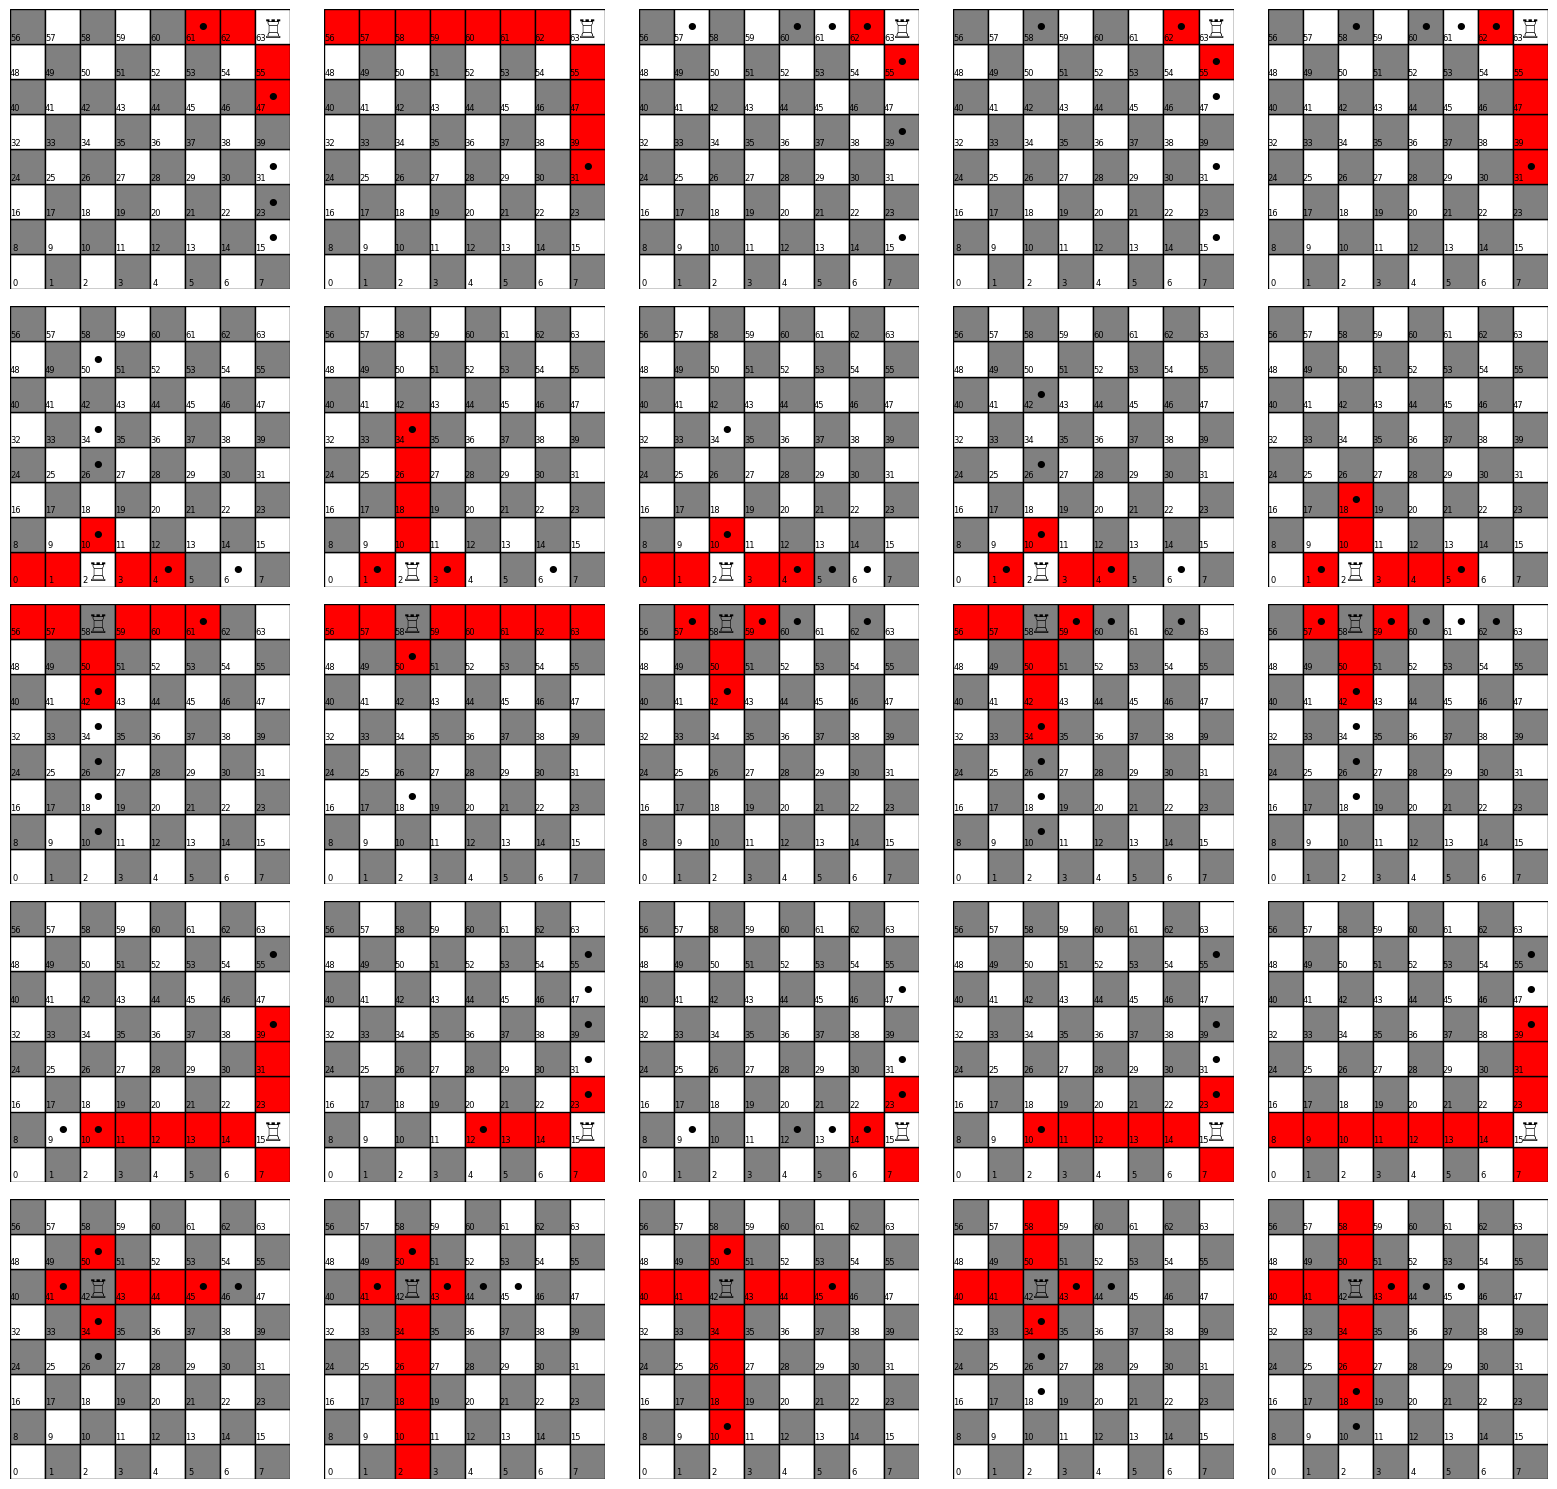

In [7]:
show_random_positions(5, rook_almost_magic_table)

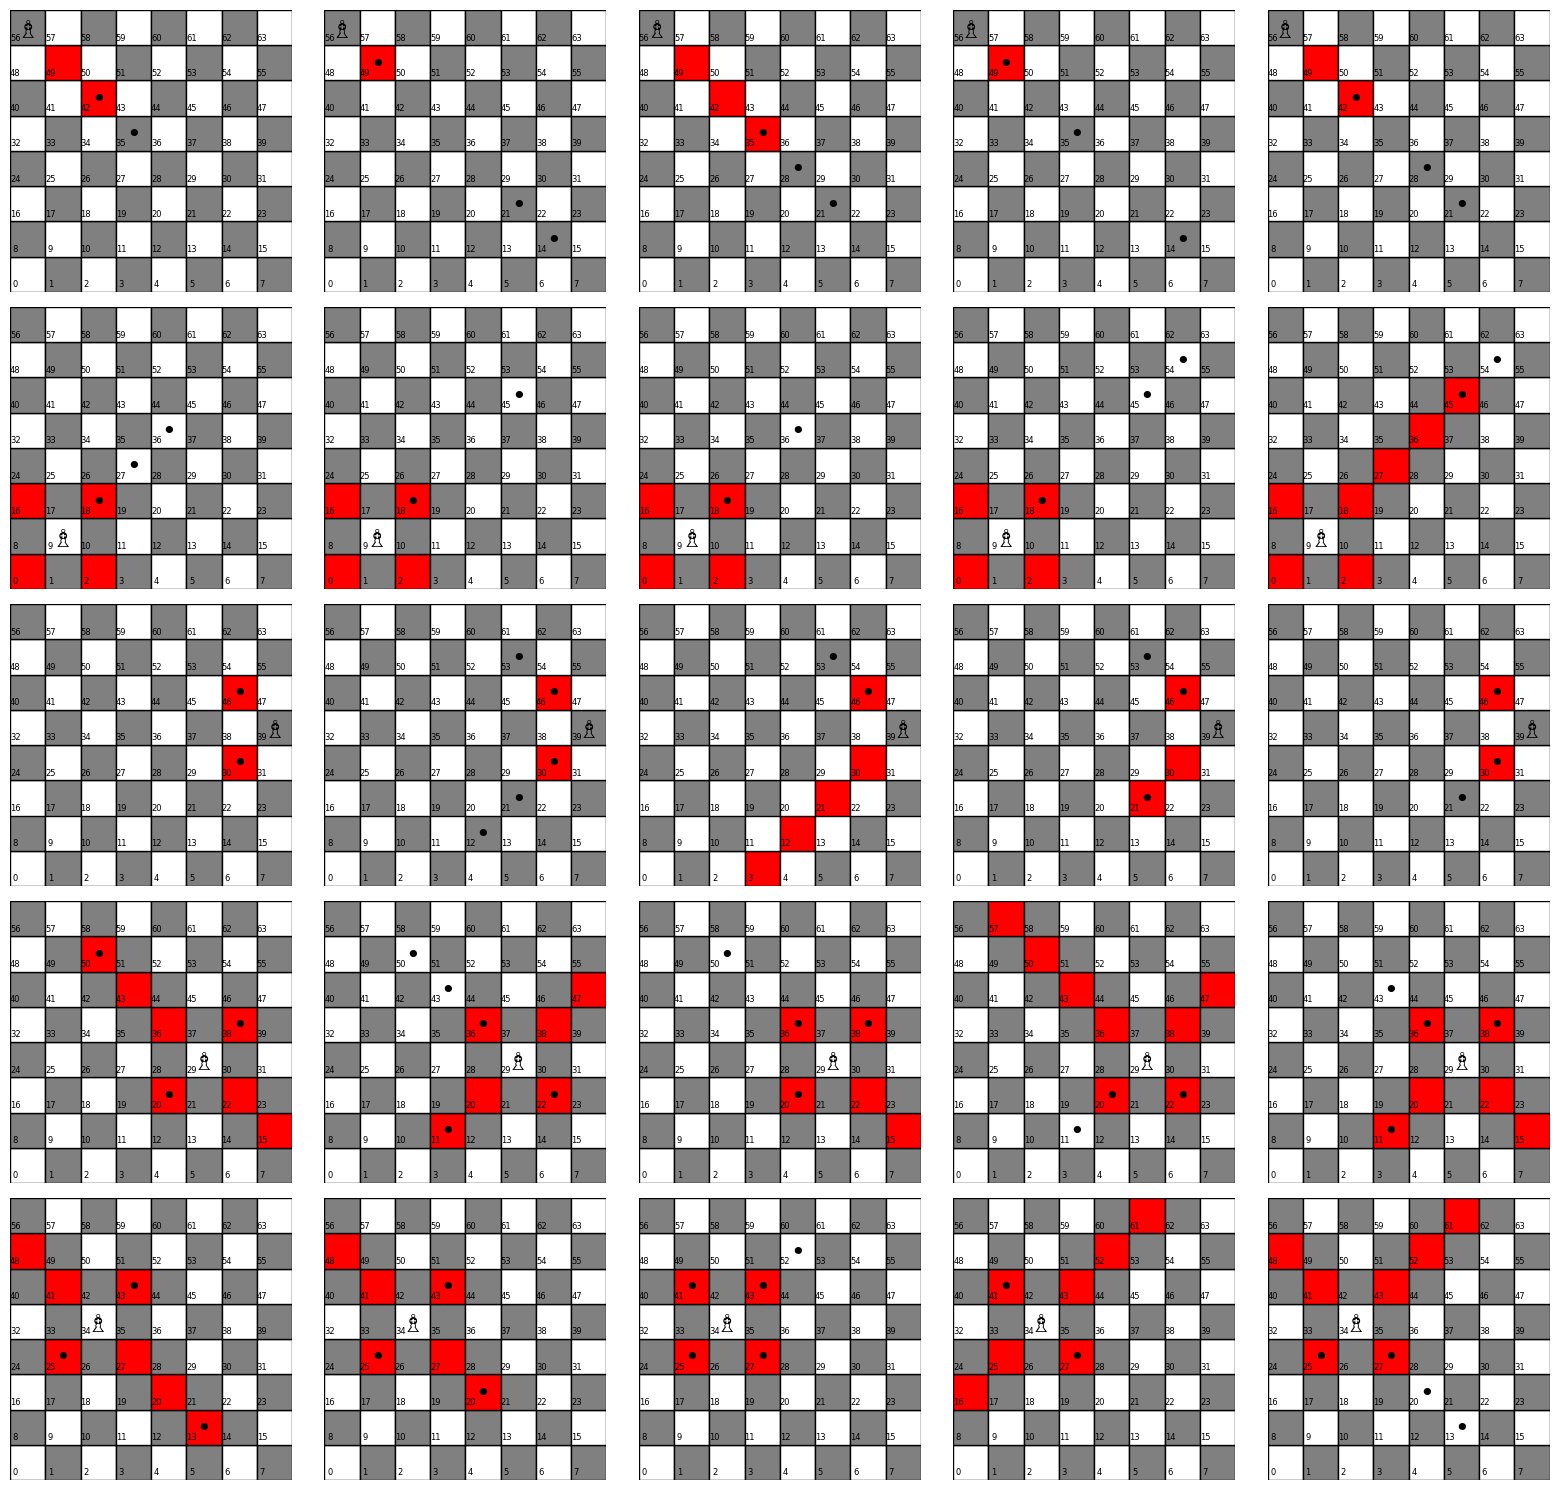

In [8]:
show_random_positions(5, bishop_almost_magic_table,'♗')

In [9]:
def popcount(x):
    return bin(x).count('1')

def transform(blocker, magic, bits):
    return ((blocker * magic) >> (64 - bits)) & ((1 << bits) - 1)

def random_uint64():
    return random.getrandbits(64)


def random_uint64_fewbits():
    return random_uint64() & random_uint64() & random_uint64()

def index_to_uint64(index, bits, mask):
    result = 0
    bit_positions = [i for i in range(64) if (mask >> i) & 1]
    for i in range(bits):
        if index & (1 << i):
            result |= 1 << bit_positions[i]
    return result

def find_magic(square, relevant_bits, is_bishop):
    if is_bishop:
        mask = generate_bishop_blocker_mask(square)
        get_attack = compute_bishop_attacks
    else:
        mask = generate_rook_blocker_mask(square)
        get_attack = compute_rook_attacks

    occupancy_variations = generate_blocker_variations(mask)
    attack_map = {b: get_attack(square, b) for b in occupancy_variations}

    for _ in range(100_000_000):
        magic = random_uint64_fewbits()

        if popcount((mask * magic) & 0xFF00000000000000) < 6:
            continue

        used = {}
        fail = False
        for blocker in occupancy_variations:
            index = transform(blocker, magic, relevant_bits)

            attack = attack_map[blocker]
            if index in used and used[index] != attack:
                fail = True
                break
            used[index] = attack

        if not fail:
            return magic

    print(f"***Failed for square {square}***")
    return 0



In [10]:
rook_mb = []
bishop_mb = []

print("Rook:")
for i in range(64):
    rook_mb.append(find_magic(i, 12, False))
    print(rook_mb[-1])

print("\nBishop:")
for i in range(64):
    bishop_mb.append(find_magic(i, 9, True))
    print(bishop_mb[-1])



Rook:
612490099616137216
297272760046979072
290486711451942920
108088659948929032
9241390867770638337
721701857474380288
144115465537458436
72066667257045760
18023194875142152
4620732804429776898
563362274607120
4900233105467637792
4512395741757696
1548115861635584
109214498585381376
360850920714797249
594475185443405832
2322761397580800
211116035671045
148654008616092800
145241367291904144
343064874852608
1126175892070666
4611972029023797376
148618865147117644
14123332412973264912
2540034622276829248
5913226602862619212
18032025592463490
2738470057143175360
145804051894927427
5189554283456102465
1196271008219168
9223970377338980480
54193038351766689
6917814909255286786
52810920231424
324967258692538632
9227910842366822402
4614087921446684165
18049666633435136
23654344477906944
6877719568449
72203004719661312
1126726725797890
2449959307555446800
287762843680
360780005377
9223759074489794880
567350156331010
297449241061638224
141014782182186
6918656039004939266
153267522899017856
562954

In [11]:
ROOK_TABLE_SIZE = 4096 * 64   # 262 144 elementów
BISHOP_TABLE_SIZE = 512 * 64  # 32 768 elementów

rook_magic_table = [0] * ROOK_TABLE_SIZE
bishop_magic_table = [0] * BISHOP_TABLE_SIZE

for i in range(64):
    # Dla wieży
    for blockers in rook_almost_magic_table[i]:
        magic_index = transform(blockers, rook_mb[i], 12)
        index = magic_index + 4096 * i
        rook_magic_table[index] = rook_almost_magic_table[i][blockers]

    # Dla gońca
    shift = 64 - 9
    for blockers in bishop_almost_magic_table[i]:
        magic_index = transform(blockers, bishop_mb[i], 9)
        index = magic_index + 512 * i
        bishop_magic_table[index] = bishop_almost_magic_table[i][blockers]

In [12]:
def to_cpp_u64(x):
    return f"0x{x:016X}ULL"

def generate_cpp_rook_header():

    rook_masks = [generate_rook_blocker_mask(i) for i in range(64)]

    with open("RookMagicBitboards.h", "w") as f:
        f.write("#pragma once\n")
        f.write("#include <array>\n#include \"../BitboardsUtils.h\"\n\n")
        f.write("class RookMagicBitboards\n{\npublic:\n")

        f.write("\tstatic u64 GetMovesMask(int square, u64 blockers)\n\t{\n")
        f.write("\t\treturn m_MovesDictionary[4096 * square + ((m_MagicNumbers[square] * blockers) >> 52)];\n")
        f.write("\t}\n\n")

        f.write("\tstatic u64 GetBlockersMask(int square)\n\t{\n")
        f.write("\t\treturn m_BlockerMasks[square];\n\t}\n")

        f.write("\nprivate:\n")
        f.write("\tstatic constexpr std::array<u64, 64> m_BlockerMasks = {\n\t\t")
        for i, mask in enumerate(rook_masks):
            f.write(to_cpp_u64(mask))
            if i != 63:
                f.write(", ")
                if (i + 1) % 8 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("\tstatic constexpr std::array<u64, 64> m_MagicNumbers = {\n\t\t")
        for i, magic in enumerate(rook_mb):
            f.write(to_cpp_u64(magic))
            if i != 63:
                f.write(", ")
                if (i + 1) % 8 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("\tstatic constexpr std::array<u64, 262144> m_MovesDictionary = {\n\t\t")
        for i, bitboard in enumerate(rook_magic_table):
            f.write(to_cpp_u64(bitboard))
            if i != 262143:
                f.write(", ")
                if (i + 1) % 8 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("};\n")

def generate_cpp_bishop_header():
    bishop_masks = [generate_bishop_blocker_mask(i) for i in range(64)]

    with open("BishopMagicBitboards.h", "w") as f:
        f.write("#pragma once\n")
        f.write("#include <array>\n#include \"../BitboardsUtils.h\"\n\n")
        f.write("class BishopMagicBitboards\n{\npublic:\n")

        f.write("\tstatic u64 GetMovesMask(int square, u64 blockers)\n\t{\n")
        f.write("\t\treturn m_MovesDictionary[512 * square + ((m_MagicNumbers[square] * blockers) >> 55)];\n")
        f.write("\t}\n\n")

        f.write("\tstatic u64 GetBlockersMask(int square)\n\t{\n")
        f.write("\t\treturn m_BlockerMasks[square];\n\t}\n")

        f.write("\nprivate:\n")
        f.write("\tstatic constexpr std::array<u64, 64> m_BlockerMasks = {\n\t\t")
        for i, mask in enumerate(bishop_masks):
            f.write(to_cpp_u64(mask))
            if i != 63:
                f.write(", ")
                if (i + 1) % 8 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("\tstatic constexpr std::array<u64, 64> m_MagicNumbers = {\n\t\t")
        for i, magic in enumerate(bishop_mb):
            f.write(to_cpp_u64(magic))
            if i != 63:
                f.write(", ")
                if (i + 1) % 8 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("\tstatic constexpr std::array<u64, 32768> m_MovesDictionary = {\n\t\t")
        for i, bitboard in enumerate(bishop_magic_table):
            f.write(to_cpp_u64(bitboard))
            if i != 32767:
                f.write(", ")
                if (i + 1) % 8 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("};\n")



In [13]:
generate_cpp_rook_header()

In [14]:
generate_cpp_bishop_header()